## 0. Define Functions

### 0.1 Moving Average Function

In [5]:
# Define a function that will calculate moving averages
def calculate_ema_mov_avg(df_close, N=100):
    '''
    This function will return a dataframe with a new moving average 
    column given the dataframe and number of days that would like to be averaged
    1. Calculate Simple Moving Average (SMA)
    2. Calculate the weight multiplier for EMA
    3. Calculate the current Exponential Moving Average
    '''
    # Create a date array for indexing through data frame
    EMA_array = np.zeros(len(df_close))
    period_sum = 0
    n = str(N)
    
    for i in range(len(df_close)):
        if i < N:
            # Skip initial moving averages as there will be no data to calculate them
            i = i + 1
            continue
        # 1. Calculate Simple Moving Average
        for j in range(1,N+1):
            # 1.1 Calculate period sum
            period_sum = period_sum + df_close.iloc[i-j]
        SMA = (N-period_sum)/N
        period_sum = 0 # Set back to 0 (******Look into easy optimization to avoid repeat summations in future)
        
        # 2. Calculate Weighted Average (k)
        k = 2 / (N + 1)
        
        # 3. Calculate Exponential Moving Average
        price_t = df_close.iloc[i]
        EMA_y = EMA_array[i-1]
        EMA = ( price_t * k ) + (EMA_y * (1 - k))
        
        # 4. Put calculated EMA into EMA array
        EMA_array[i] = EMA
                
    EMA_array
    return EMA_array

### 0.2 Make Predictions Function

In [94]:
def future_predictions(diff_data, last_obs, model, num_p=50):
    '''
    This function will predict n amounts of future observations
    '''
    new_predictions = np.zeros(num_p)
    # future_predictions = model.predict(start=len(diff_data), end=len(diff_data)+num_p)
    
    for i in range(num_p):   
        future_predictions = model.predict(start=len(diff_data), end=len(diff_data))
        new_predictions[i] = future_predictions[i] + last_obs
        next_value = new_predictions[i]-last_obs
        diff_data = np.append(diff_data, next_value)
        last_obs = new_predictions[i]
        
        # Add verbose to show progress
        for j in range (10,110,10):
            if i == int(num_p * j/100): 
                print(f'Prediction progress: {j}%...')            
    print('Done!')
    return new_predictions

### 0.3 Calculate Difference Array Function

In [7]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return np.array(diff)

### 0.4 Test Predictions Function

In [8]:
def test_predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat = yhat + coef[i] * history[-i]
    return yhat

## 1. Read and Preprocess Data

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import datetime as dt

In [10]:
# Read in Dataframe
VFV_df = pd.read_csv('data/VFV_TO.csv')

# Make headings lowercase
VFV_df.rename(str.lower, axis=1, inplace=True)

# Change date column formating
VFV_df['date'] = pd.to_datetime(VFV_df.date, format='%Y-%m-%d')

In [11]:
# Add an n_days day estimated moving average
ema_n_days = 100
ema_array = calculate_ema_mov_avg(VFV_df['close'], N=ema_n_days)
VFV_df['ema'] = ema_array

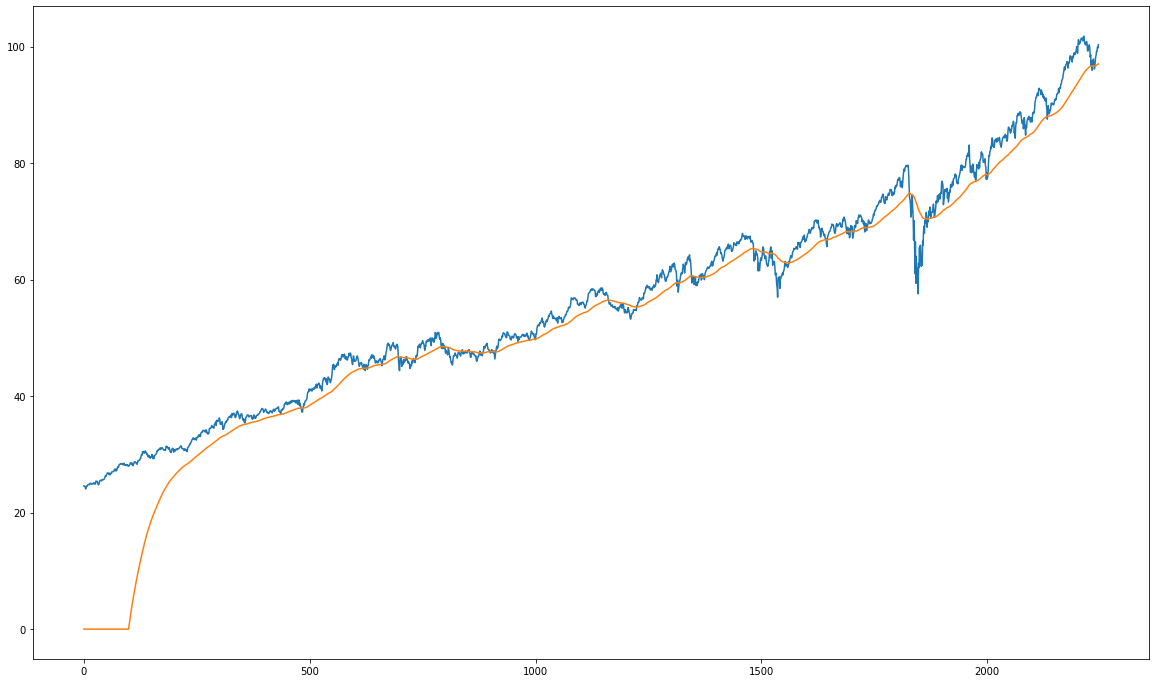

In [12]:
# Set figure and axis'
fig, ax = plt.subplots(figsize=(20,12))
close_plot = ax.plot(VFV_df['close'])
ema_plot = ax.plot(VFV_df['ema'])

## 2. Create Auto Regression Model

In [121]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoRegResults
from sklearn.metrics import mean_squared_error
from math import sqrt

In [122]:
# Create numpy arrays for close and ema values
close_values = np.array(VFV_df['close'].values)
ema_values = np.array(VFV_df['ema'].values)

In [123]:
# Create difference arrays for both close and ema
close_diffs = difference(close_values)
ema_diffs = difference(ema_values)

In [202]:
# Set training size
train_size = int(len(close_diffs) * 0.75)

In [203]:
# Set figure and axis'
# fig, ax = plt.subplots(figsize=(20,12))
# close_diff_plot = ax.plot(close_diffs)

In [204]:
# fig, ax = plt.subplots(figsize=(20,12))
# ema_diff_plot = ax.plot(ema_diffs[2*ema_n_days:])

In [205]:
# Set training and testing data
close_train, close_test = close_diffs[:train_size], close_diffs[train_size:]
ema_train, ema_test = ema_diffs[2*ema_n_days:train_size], ema_diffs[train_size:]

In [214]:
window_size = 350

In [215]:
# Train the auto regression models
close_model = AutoReg(close_train, lags=window_size)
close_fit = close_model.fit()
close_coef = close_fit.params

In [216]:
# Train the auto regression models
ema_model = AutoReg(ema_train, lags=window_size)
ema_fit = ema_model.fit()
ema_coef = ema_fit.params

In [217]:
# Walk forward over time steps
close_history = [close_train[i] for i in range(len(close_train))]
ema_history = [ema_train[i] for i in range(len(ema_train))]
close_predictions = []
ema_predictions = []

In [218]:
# Make test predictions
for t in range(len(close_test)):
    yhat = test_predict(close_coef, close_history)
    obs = close_test[t]
    close_predictions.append(yhat)
    close_history.append(obs)

In [219]:
mse = mean_squared_error(close_test, close_predictions)
mse

1.416990178263927

In [220]:
rmse = sqrt(mse)
rmse

1.1903739657199863

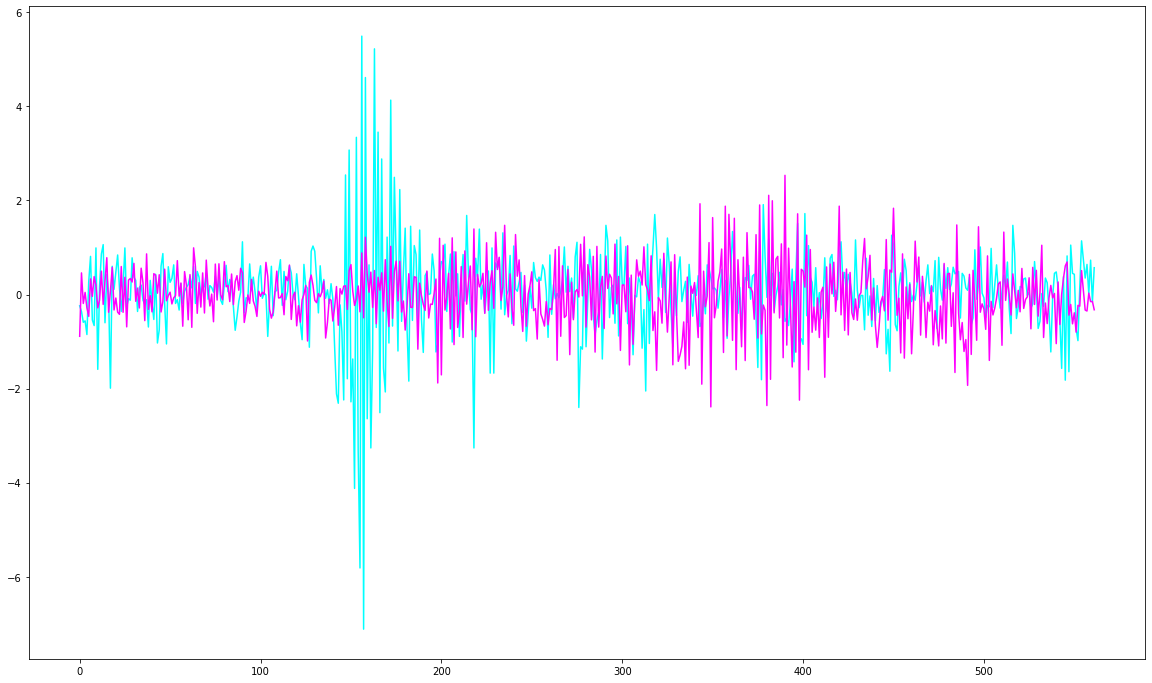

In [221]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(close_test, color='cyan')
ax.plot(close_predictions, color='magenta')

In [222]:
# Set the number of predictions
num_preds = 500

In [223]:
train_values = close_values[:train_size]

In [224]:
# Predict on train data
train_preds = future_predictions(diff_data=close_train, last_obs=train_values[-1], model=close_fit, num_p=len(close_test)+1)

Prediction progress: 10%...
Prediction progress: 20%...
Prediction progress: 30%...
Prediction progress: 40%...
Prediction progress: 50%...
Prediction progress: 60%...
Prediction progress: 70%...
Prediction progress: 80%...
Prediction progress: 90%...
Done!


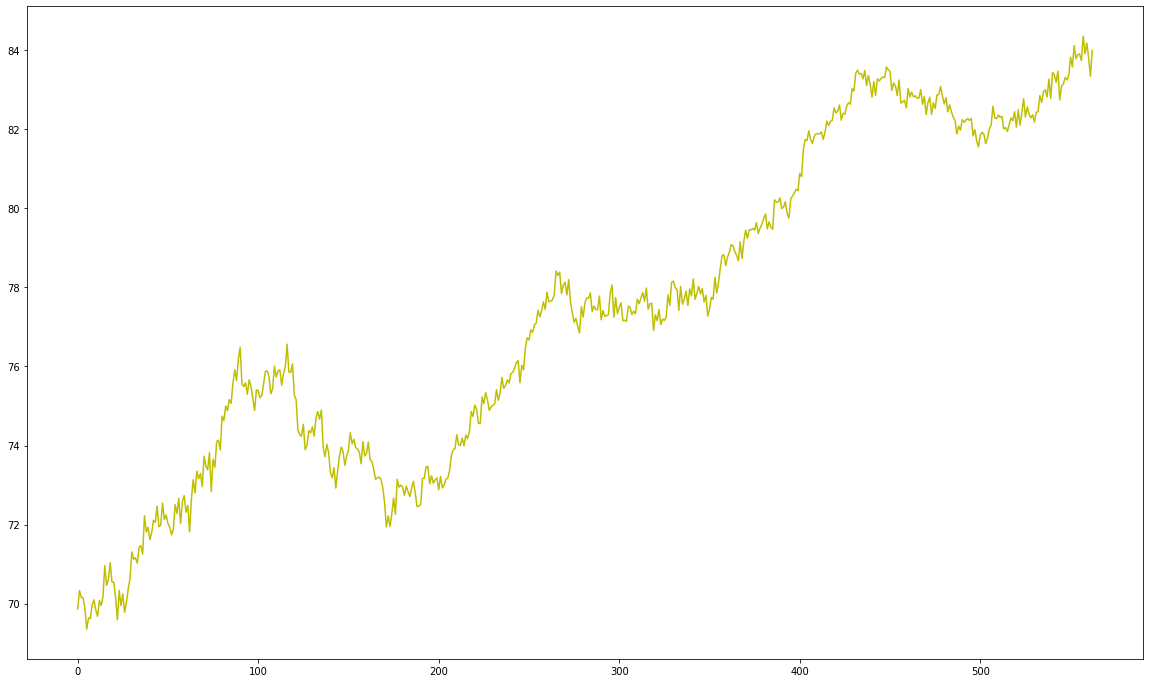

In [225]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(train_preds, color='y')

In [229]:
len(train_values), len(train_preds)

(1684, 563)

In [227]:
train_df = VFV_df
train_df['train_predictions'] = np.append(train_values, train_preds)

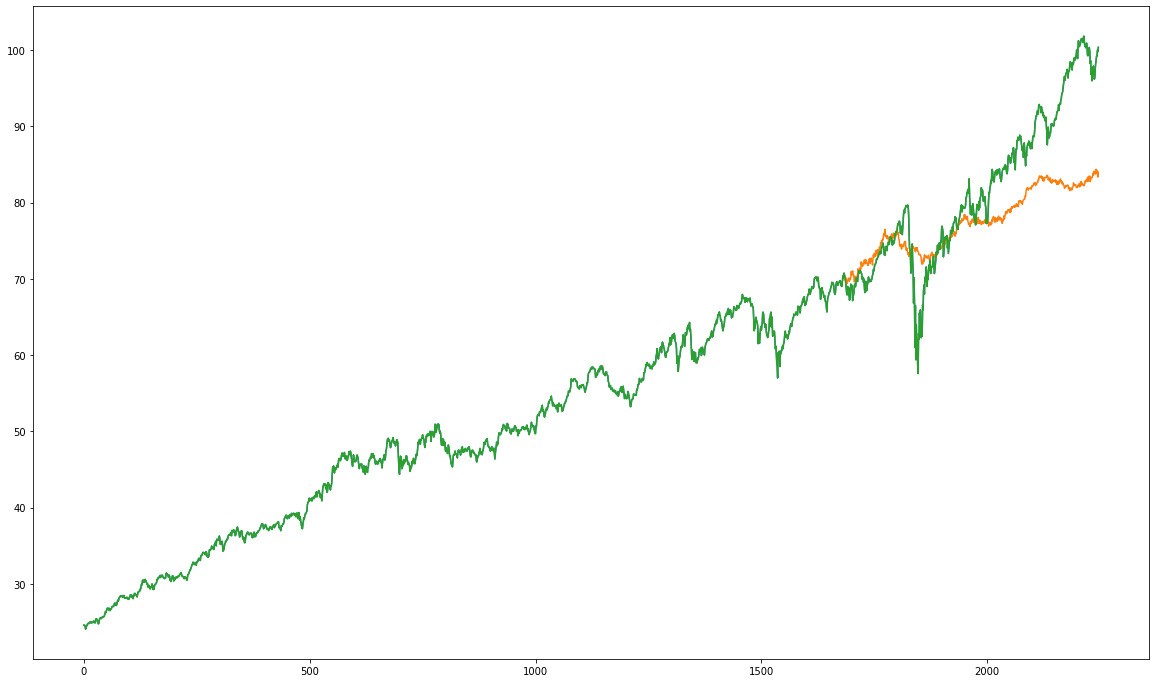

In [228]:
fig,ax = plt.subplots(figsize=(20,12))
train_plot = ax.plot(train_df['close'])
pred_plot = ax.plot(train_df['train_predictions'][train_size:])
train_plot = ax.plot(train_df['close'])

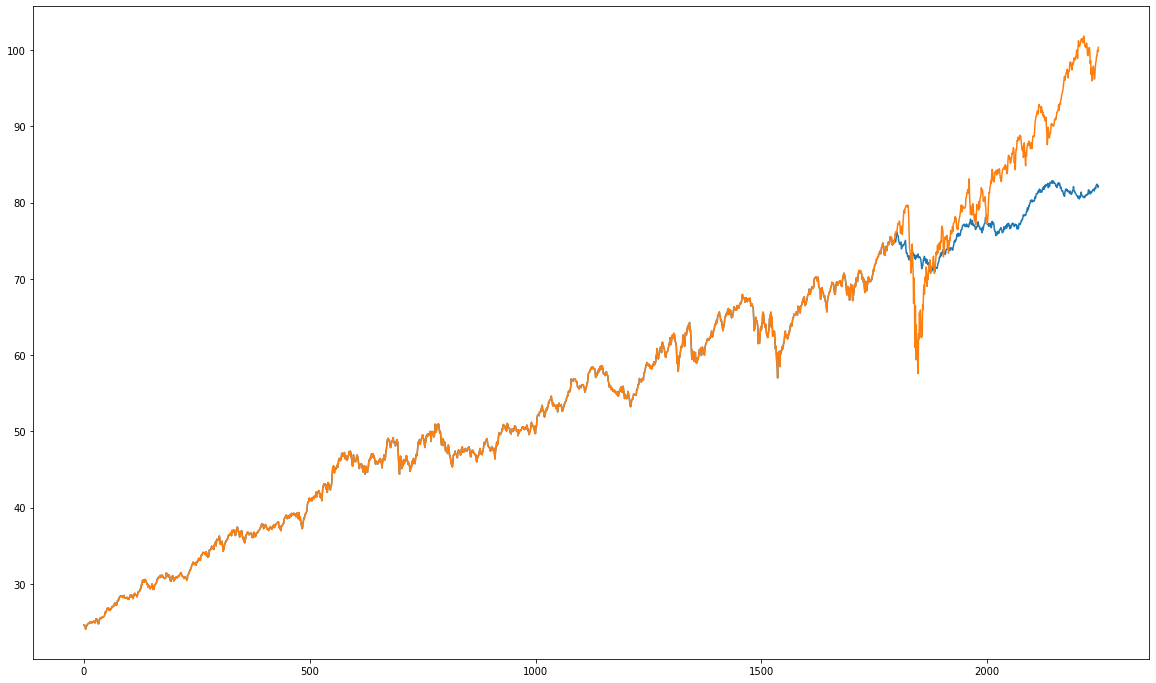

In [77]:
fig,ax = plt.subplots(figsize=(20,12))
pred_plot = ax.plot(train_df['train_predictions'])
train_plot = ax.plot(train_df['close'])

In [53]:
close_preds = future_predictions(diff_data=close_diffs, last_obs=close_values[-1], model=close_fit, num_p=num_preds)

Prediction progress: 10%...
Prediction progress: 20%...
Prediction progress: 30%...
Prediction progress: 40%...
Prediction progress: 50%...
Prediction progress: 60%...
Prediction progress: 70%...
Prediction progress: 80%...
Prediction progress: 90%...
Done!


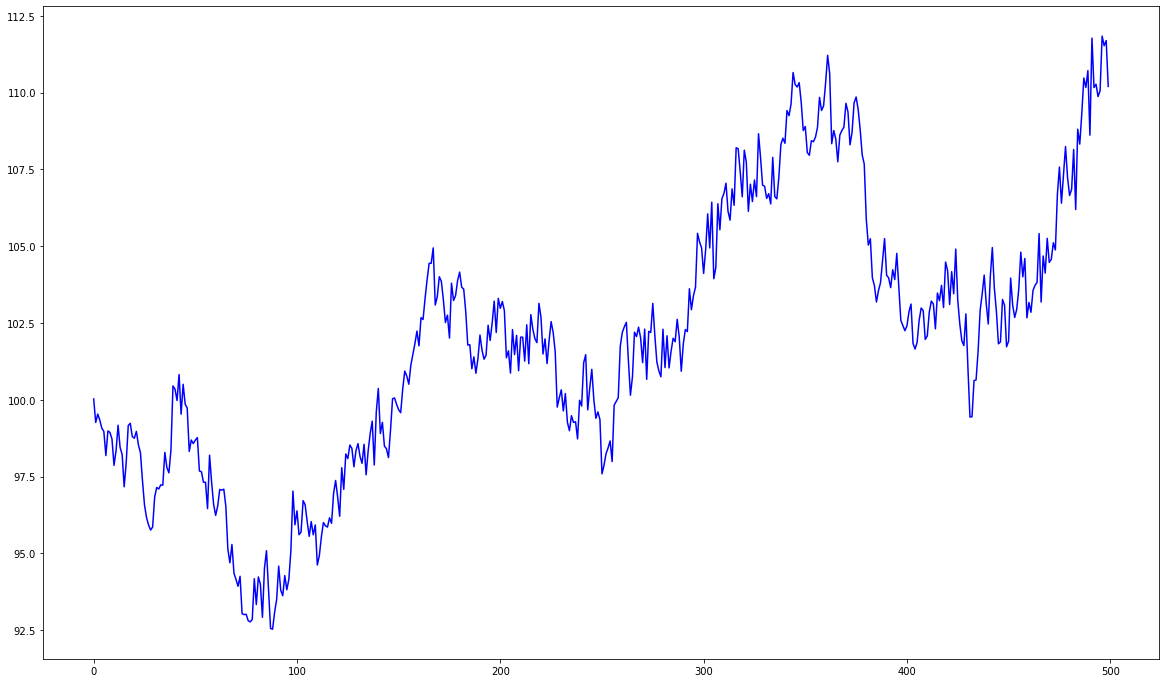

In [392]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(close_preds, color='blue')

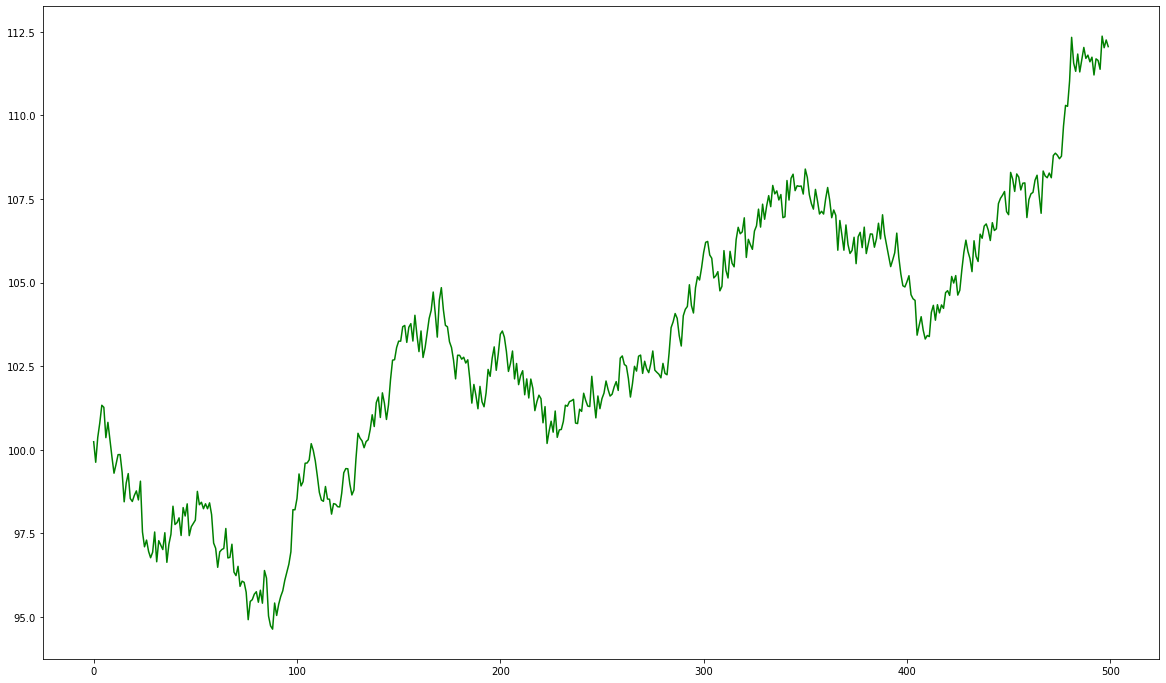

In [367]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(close_preds, color='green')

In [393]:
VFV_df.drop(columns=['predictions'], inplace=True)

In [394]:
prediction_df = VFV_df

In [395]:
prediction_df['predictions'] = prediction_df['close']

In [396]:
# Append new predictions onto prediction column
for i in range(len(close_preds)):
    prediction_df = prediction_df.append({'predictions':close_preds[i]}, ignore_index=True)

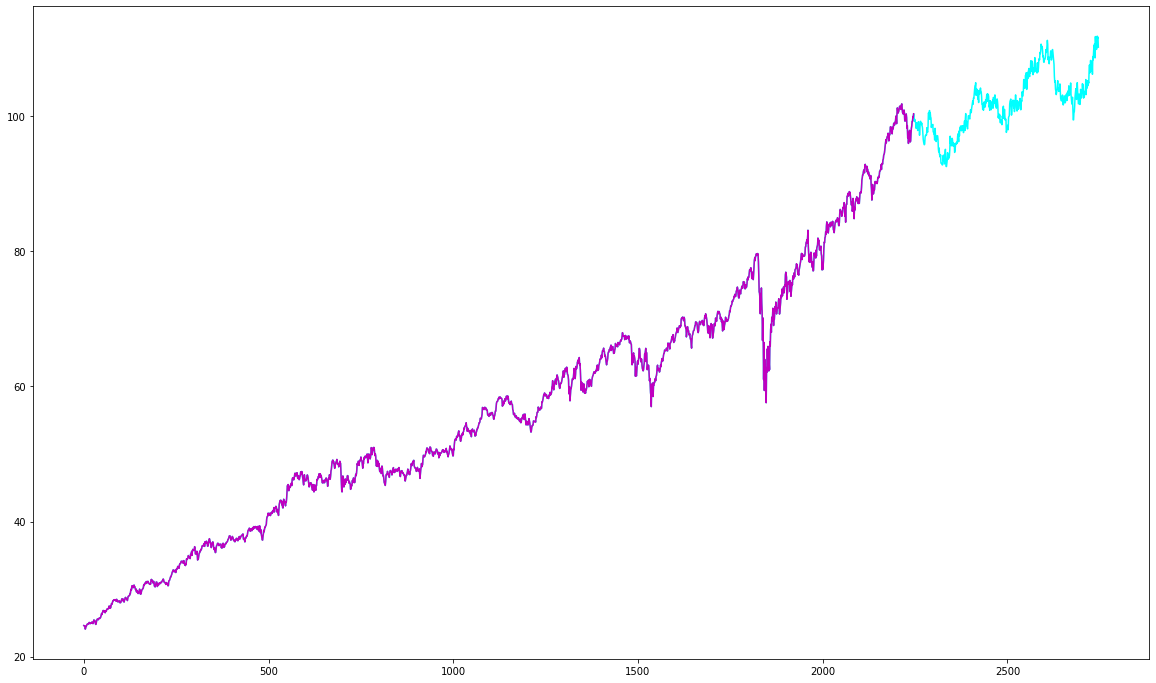

In [397]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(prediction_df['predictions'], color='cyan')
ax.plot(VFV_df['close'], color = 'm')

In [398]:
for i in range(10,110,10):
    print(i)

10
20
30
40
50
60
70
80
90
100


In [399]:
new_ema = calculate_ema_mov_avg(prediction_df['predictions'], 100)

In [400]:
prediction_df['pred_ema'] = new_ema

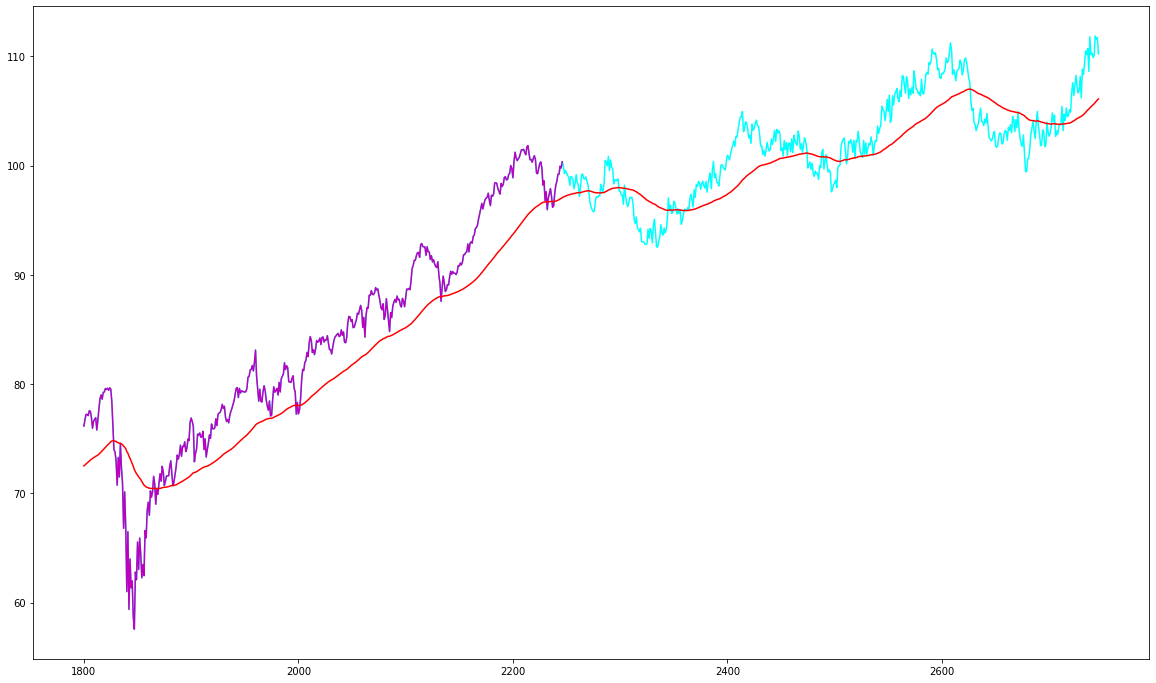

In [401]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(prediction_df['predictions'][1800:], color='cyan')
ax.plot(VFV_df['close'][1800:], color = 'm')
ax.plot(prediction_df['pred_ema'][1800:], color = 'r')